# Dask through Jupyter Notebooks

This notebook will guide you through using Dask to analyze NanoAOD root files using a Slurm Cluster on SubMIT. This notebook utilizes a conda environment and then exports that environment in the slurm jobs. Follow the README for instructions on the conda environment. 

In [1]:
import os
import sys
import json
import time
import random
import numpy as np
from coffea import hist, processor
from hist import Hist
import matplotlib

from dask_jobqueue import SLURMCluster
from distributed import Client
from dask.distributed import performance_report

/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


We set up a coffea ABC Processor to analyze the ROOT files. Here we grab the Muon and Electron collection and add some simple selections using awkward.

In [87]:
import awkward as ak
import vector
vector.register_awkward()

class Simple_Process(processor.ProcessorABC):
    def __init__(self, isMC: int, era: int, sample: str) -> None:
        self.gensumweight = 1.0
        self.era = era
        self.isMC = isMC
        self.sample = sample

        self._accumulator = processor.dict_accumulator(
            {
                "ht_ak4": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("ht_ak4", r"$H_T$ [GeV]", [0,30,60,90,120,150,180,210,240,270,300,350,400,450,500,550,600,700,800,900,1000,1100,1300,1500,3000]),
                ),
                "ntracks": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("ntracks", r"$N_{tracks}$", 250, 0, 1000),
                ),
                "nmuons": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("nmuons", r"$N_{muons}$", 10, 0, 10),
                ),
                "muon_pt": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("muon_pt", r"$Muon p_{T}$ [GeV]", 100, 0, 100),
                ),
                "sumw": processor.defaultdict_accumulator(float),
            }
        )
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator
        dataset = events.metadata['dataset']

        if self.isMC: self.gensumweight = ak.sum(events.genWeight)
        
        output["sumw"][dataset] += ak.sum(events.genWeight)
        
        # gen particles
        particles = ak.zip({
            "pt": events.GenPart.pt,
            "eta": events.GenPart.eta,
            "phi": events.GenPart.phi,
            "mass": events.GenPart.mass,
            "pdgId": events.GenPart.pdgId
        }, with_name="Momentum4D")
        cut = (events.GenPart.status == 1) & \
              (particles.pt > 0.7) & \
              (abs(particles.eta) < 2.5)
        particles = particles[cut]
        muons = particles[abs(particles.pdgId)==13]
    

        # gen jets
        jets = ak.zip({
            "pt": events.GenJet.pt,
            "eta": events.GenJet.eta,
            "phi": events.GenJet.phi,
            "mass": events.GenJet.mass,
        }, with_name="Momentum4D")
        jetCut = (jets.pt > 30) & (abs(jets.eta)<4.7)
        jets = jets[jetCut]
                
        # fill out hists
        output['ntracks'].fill(ntracks=ak.num(particles, axis=-1), dataset=dataset)
        output['nmuons'].fill(nmuons=ak.num(muons, axis=-1), dataset=dataset)
        muons = muons[ak.num(muons, axis=-1)>0]
        output['muon_pt'].fill(muon_pt=ak.max(muons.pt, axis=-1), dataset=dataset)
        output['ht_ak4'].fill(ht_ak4=ak.sum(jets.pt,axis=-1), dataset=dataset)
        
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [3]:
def check_port(port):
    import socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    try:
        sock.bind(("0.0.0.0", port))
        available = True
    except:
        available = False
    sock.close()
    return available

The following section defines additional parts of the slurm Dask job. Here we source the bashrc to prepare Conda. We also pass in the x509 proxy. In order to share the proxy across the SubMIT machines you should move your proxy to your HOME directory.

In [4]:
slurm_env = [
     'export XRD_RUNFORKHANDLER=1',
     'export XRD_STREAMTIMEOUT=10',
     f'source {os.environ["HOME"]}/.bashrc',
     f'conda activate dask',
     f'export X509_USER_PROXY={os.environ["HOME"]}/x509up_u206148'
]

extra_args=[
     "--output=dask_job_output_%j.out",
     "--error=dask_job_output_%j.err",
     "--partition=submit",
     "--clusters=submit",
]

In [5]:
n_port       = 6820
w_port       = 9765
cores        = 1
processes    = 1
memory       = "5 GB"
chunksize    = 15000
maxchunks    = None

The following sets up the processor and json file. If you want to change files you can simply modify the json file

In [6]:
file = "../filelist/list_2018_MC_A01.txt"
samples = []
with open(file, 'r') as stream:
    for sample in stream.read().split('\n'):
        if '#' in sample: continue
        if len(sample.split('/')) <= 1: continue
        sample_name = sample.split("/")[-1]
        samples.append(sample_name)

In [7]:
samples_dict = {}
for sample_name in samples:
    if 'SUEP' in sample_name: continue
    input_list = "/home/tier3/cmsprod/catalog/t2mit/nanosu/A01/{}/RawFiles.00".format(sample_name)
    
    files = []
    Raw_list = open(input_list, "r")
    for i in Raw_list:
        file = i.split(" ")[0]
        files.append(file)
    
    samples_dict[sample_name] = files

In [8]:
suepDir = "/work/submit/freerc/Carlos/"
suep_dict = {}
for sample in os.listdir(suepDir):
    if "ggHpythia_generic" not in sample: continue
    mass = sample.split("_")[2]
    suep_dict.update({mass: [suepDir + sample + "/GEN/total.root"]})
suep_dict

{'M750': ['/work/submit/freerc/Carlos/ggHpythia_generic_M750_T2genonly/GEN/total.root'],
 'M125': ['/work/submit/freerc/Carlos/ggHpythia_generic_M125_T2genonly/GEN/total.root'],
 'M1000': ['/work/submit/freerc/Carlos/ggHpythia_generic_M1000_T2genonly/GEN/total.root'],
 'M400': ['/work/submit/freerc/Carlos/ggHpythia_generic_M400_T2genonly/GEN/total.root']}

In [9]:
# testing out the system
process_dict = {}
for key in list(samples_dict.keys()):
    process_dict.update({key:samples_dict[key][:10]})
process_dict = process_dict | suep_dict
#process_dict

In [10]:
# cross section
xsections = {}
for sample in list(process_dict.keys()):
    xsection = 1.0
    if 'QCD' in sample:
        with open('../data/xsections_{}.json'.format('2018')) as file:
            MC_xsecs = json.load(file)
            try:
                xsection *= MC_xsecs[sample]["xsec"]
                xsection *= MC_xsecs[sample]["kr"]
                xsection *= MC_xsecs[sample]["br"]
            except:
                print("WARNING: I did not find the xsection for that MC sample. Check the dataset name and the relevant yaml file")
                print(sample)
        xsections.update({sample:xsection})
    else:
        xsections.update({sample:xsection})

In [88]:
#Set up the processor
processor_instance = Simple_Process(isMC=1, era='2018', sample='test')

The next section forms the Slurm Cluster. You can set up various parameters of the cluster here.

In [13]:
if not check_port(n_port):
     raise RuntimeError("Port '{}' is occupied on this node. Try another one.".format(n_port))

import socket
cluster = SLURMCluster(
        queue='all',
        project="SUEP_Slurm",
        cores=cores,
        processes=processes,
        memory=memory,
        #retries=10,
        walltime='00:30:00',
        scheduler_options={
              'port': n_port,
              'dashboard_address': 8000,
              'host': socket.gethostname()
        },
        job_extra=extra_args,
        env_extra=slurm_env,
)

/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8000 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46599 instead
  warnings.warn(


In [14]:
cluster.adapt(minimum=1, maximum=250)
client = Client(cluster)
print(client)

<Client: 'tcp://18.12.2.18:6820' processes=0 threads=0, memory=0 B>


# Running the processor
Now we will run the code with a performance report. This will analyze all of the input ROOT files and will store the histograms in output. Then we can analyze the output and make plots.

In [90]:
with performance_report(filename="dask-report.html"):
    output = processor.run_uproot_job(process_dict,
             treename='Events',
             processor_instance=processor_instance,
             executor=processor.dask_executor,
             executor_args={
                           'client': client,
                           #'skipbadfiles': skipbadfiles,
                           'schema': processor.NanoAODSchema,
                           'xrootdtimeout': 10,
                           'retries': 3,
                           },
             chunksize=chunksize,
             maxchunks=maxchunks)

In [16]:
client.cancel(cluster)

In [17]:
from coffea.hist import plot
import matplotlib.pyplot as plt

# FIXME: SOMETHING TO NORMALIZE EACH QCD BIN HIST BY THE XSECTION AND THEN ADD THEM TOGETHER

/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/coffea/hist/plot.py:333: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/coffea/hist/plot.py:333: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/coffea/hist/plot.py:333: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/coffea/hist/plot.py:333: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)
/tmp/ipykernel_207355/2434764999.py:18: UserWarning: Attempted to set non-positive bottom ylim on a 

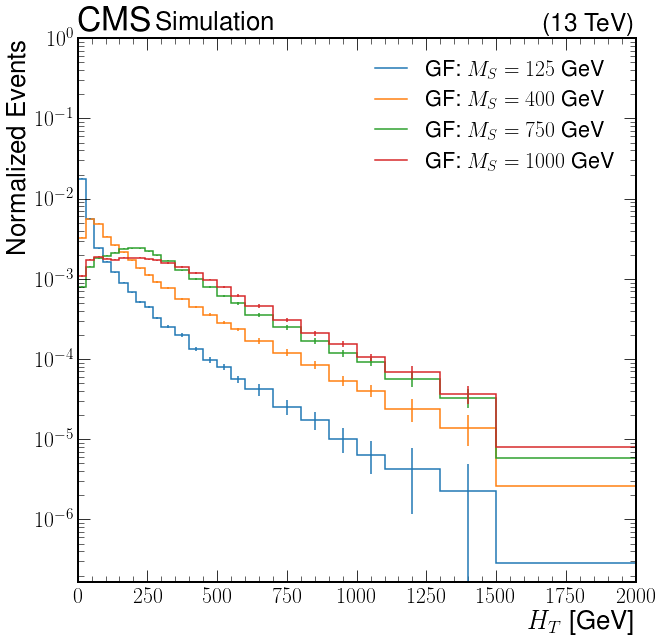

In [57]:
fig = plt.figure()
ax = fig.subplots()

import mplhep as hep
#hep.cms.label(data=False, year='2018')
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)
#_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
#plot.plot1d(h, ax=ax, clear=False, density=True)
plot.plot1d(output['ht_ak4']["M125"], ax=ax, clear=False, density=True)
plot.plot1d(output['ht_ak4']["M400"], ax=ax, clear=False, density=True)
plot.plot1d(output['ht_ak4']["M750"], ax=ax, clear=False, density=True)
plot.plot1d(output['ht_ak4']["M1000"], ax=ax, clear=False, density=True)

_ = ax.set_xlim(0,2000)
_ = ax.set_ylim(0, 1)
_ = ax.set_ylabel("Normalized Events")
plt.rcParams['text.usetex'] = True
labels = [r"GF: $M_{S}=125$ GeV",r"GF: $M_{S}=400$ GeV",r"GF: $M_{S}=750$ GeV",r"GF: $M_{S}=1000$ GeV"]

leg = ax.legend(labels=labels)


/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/coffea/hist/plot.py:333: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value enco

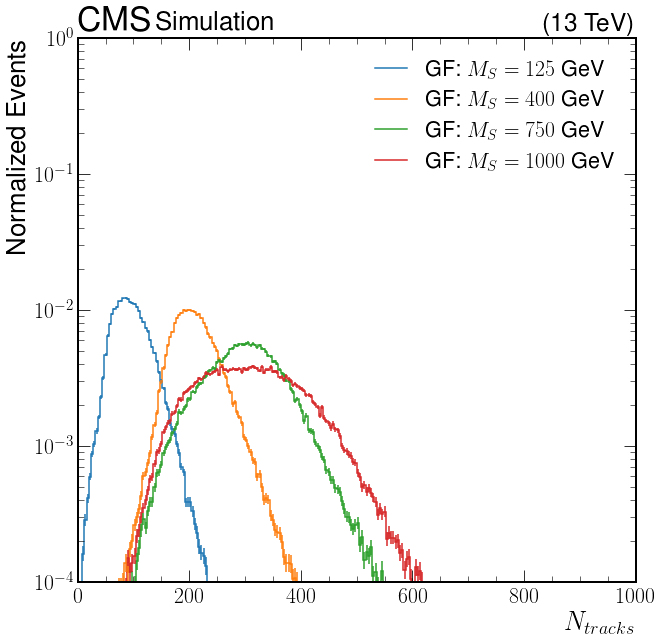

In [92]:
fig = plt.figure()
ax = fig.subplots()

import mplhep as hep
#hep.cms.label(data=False, year='2018')
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)
#_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
#plot.plot1d(h, ax=ax, clear=False, density=True)
plot.plot1d(output['ntracks']["M125"], ax=ax, clear=False, density=True)
plot.plot1d(output['ntracks']["M400"], ax=ax, clear=False, density=True)
plot.plot1d(output['ntracks']["M750"], ax=ax, clear=False, density=True)
plot.plot1d(output['ntracks']["M1000"], ax=ax, clear=False, density=True)

_ = ax.set_xlim(0,1000)
_ = ax.set_ylim(0.0001, 1)
_ = ax.set_ylabel("Normalized Events")
plt.rcParams['text.usetex'] = True
labels = [r"GF: $M_{S}=125$ GeV",r"GF: $M_{S}=400$ GeV",r"GF: $M_{S}=750$ GeV",r"GF: $M_{S}=1000$ GeV"]

leg = ax.legend(labels=labels)

/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/coffea/hist/plot.py:333: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value enco

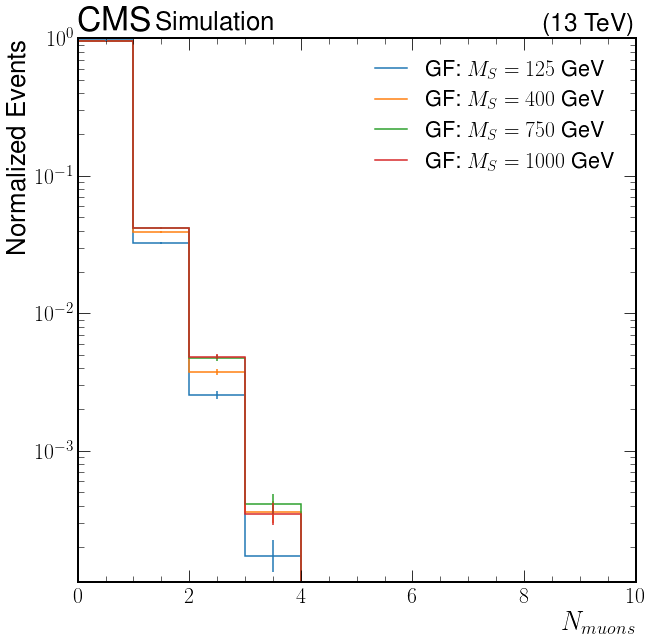

In [95]:
fig = plt.figure()
ax = fig.subplots()

import mplhep as hep
#hep.cms.label(data=False, year='2018')
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)
#_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
#plot.plot1d(h, ax=ax, clear=False, density=True)
plot.plot1d(output['nmuons']["M125"], ax=ax, clear=False, density=True)
plot.plot1d(output['nmuons']["M400"], ax=ax, clear=False, density=True)
plot.plot1d(output['nmuons']["M750"], ax=ax, clear=False, density=True)
plot.plot1d(output['nmuons']["M1000"], ax=ax, clear=False, density=True)

_ = ax.set_xlim(0,10)
_ = ax.set_ylim(0, 1)
_ = ax.set_ylabel("Normalized Events")
plt.rcParams['text.usetex'] = True
labels = [r"GF: $M_{S}=125$ GeV",r"GF: $M_{S}=400$ GeV",r"GF: $M_{S}=750$ GeV",r"GF: $M_{S}=1000$ GeV"]

leg = ax.legend(labels=labels)

/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/coffea/hist/plot.py:333: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value enco

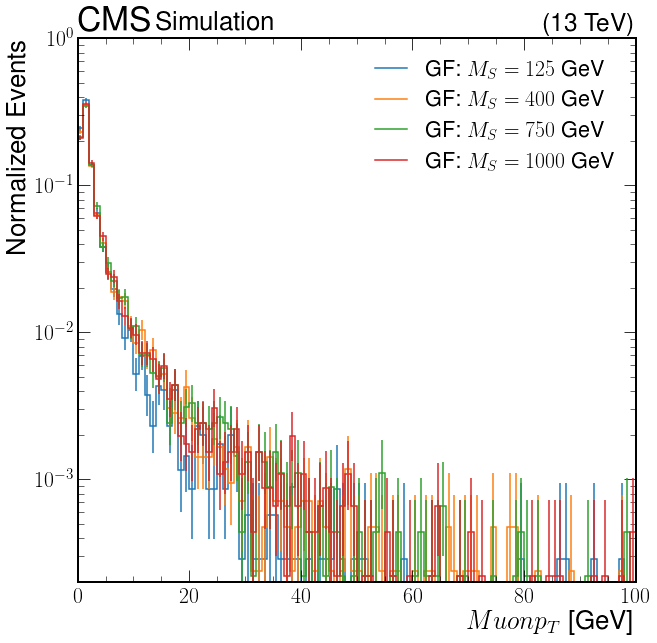

In [96]:
fig = plt.figure()
ax = fig.subplots()

import mplhep as hep
#hep.cms.label(data=False, year='2018')
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)
#_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
#plot.plot1d(h, ax=ax, clear=False, density=True)
plot.plot1d(output['muon_pt']["M125"], ax=ax, clear=False, density=True)
plot.plot1d(output['muon_pt']["M400"], ax=ax, clear=False, density=True)
plot.plot1d(output['muon_pt']["M750"], ax=ax, clear=False, density=True)
plot.plot1d(output['muon_pt']["M1000"], ax=ax, clear=False, density=True)

_ = ax.set_xlim(0,100)
_ = ax.set_ylim(0, 1)
_ = ax.set_ylabel("Normalized Events")
plt.rcParams['text.usetex'] = True
labels = [r"GF: $M_{S}=125$ GeV",r"GF: $M_{S}=400$ GeV",r"GF: $M_{S}=750$ GeV",r"GF: $M_{S}=1000$ GeV"]

leg = ax.legend(labels=labels)

In [89]:
scales = {} 
for dataset in output["sumw"]:
    xsec = xsections[dataset]
    scale = xsec / output["sumw"][dataset]
    scales.update({dataset: scale})

output["ht_ak4"].scale(scales, axis='dataset')


QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM
QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM
QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM
QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM
QCD_Pt_120to170_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM
QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM
M125
M400
M1000
QCD_Pt_80to120_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM
M750
QCD_Pt_800to1000_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM
QCD_Pt_600to800_TuneCP5_13TeV_pythia8+RunIISummer20UL18

In [94]:
QCD_Hist = output['ht_ak4']["QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"].values()+output['ht_ak4']["QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"].values()+output['ht_ak4']["QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"].values()+output['ht_ak4']["QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"].values()+output['ht_ak4']["QCD_Pt_120to170_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM"].values()+output['ht_ak4']["QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"].values()+output['ht_ak4']["QCD_Pt_80to120_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"].values()+output['ht_ak4']["QCD_Pt_800to1000_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"].values()+output['ht_ak4']["QCD_Pt_600to800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"].values()+output['ht_ak4']["QCD_Pt_50to80_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"].values()+output['ht_ak4']["QCD_Pt_470to600_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"].values()+output['ht_ak4']["QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"].values()+output['ht_ak4']["QCD_Pt_30to50_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"].values()+output['ht_ak4']["QCD_Pt_300to470_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"].values()output['ht_ak4']["QCD_Pt_2400to3200_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"].values()



SyntaxError: invalid syntax (1448358429.py, line 1)

TypeError: Cannot compare an Axis with a True

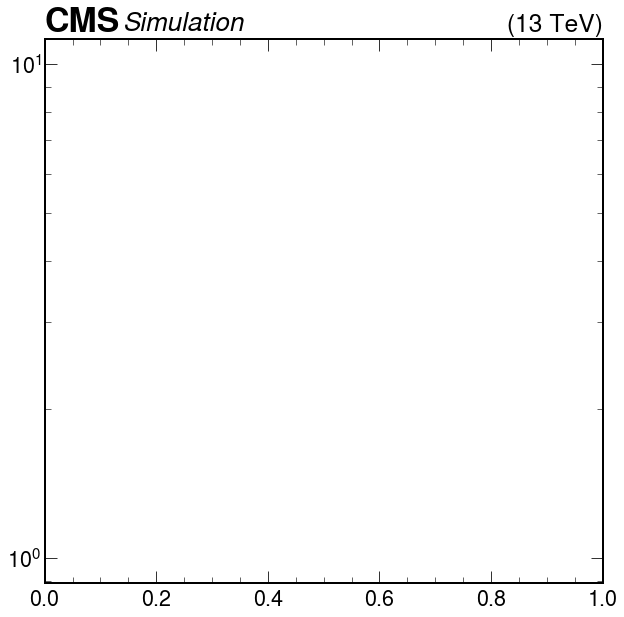

In [91]:
fig = plt.figure()
ax = fig.subplots()

import mplhep as hep
#hep.cms.label(data=False, year='2018')
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)
#_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
#plot.plot1d(h, ax=ax, clear=False, density=True)
plot.plot1d(output['ht_ak4']["QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"], ax=ax, clear=False, stack=True)
plot.plot1d(output['ht_ak4']["QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"], ax=ax, clear=False, stack=True)
plot.plot1d(output['ht_ak4']["QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"], ax=ax, clear=False, stack=True)
plot.plot1d(output['ht_ak4']["QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"], ax=ax, clear=False, stack=True)
plot.plot1d(output['ht_ak4']["QCD_Pt_120to170_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM"], ax=ax, clear=False, stack=True)
plot.plot1d(output['ht_ak4']["QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"], ax=ax, clear=False, stack=True)
plot.plot1d(output['ht_ak4']["QCD_Pt_80to120_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"], ax=ax, clear=False, stack=True)
plot.plot1d(output['ht_ak4']["QCD_Pt_800to1000_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"], ax=ax, clear=False, stack=True)
plot.plot1d(output['ht_ak4']["QCD_Pt_600to800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"], ax=ax, clear=False, stack=True)
plot.plot1d(output['ht_ak4']["QCD_Pt_50to80_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"], ax=ax, clear=False, stack=True)
plot.plot1d(output['ht_ak4']["QCD_Pt_470to600_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"], ax=ax, clear=False, stack=True)
plot.plot1d(output['ht_ak4']["QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"], ax=ax, clear=False, stack=True)
plot.plot1d(output['ht_ak4']["QCD_Pt_30to50_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"], ax=ax, clear=False, stack=True)
plot.plot1d(output['ht_ak4']["QCD_Pt_300to470_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"], ax=ax, clear=False, stack=True)
plot.plot1d(output['ht_ak4']["QCD_Pt_2400to3200_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"], ax=ax, clear=False, stack=True)

_ = ax.set_ylim(0, 100000000)
ax.get_legend().remove()


/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/coffea/hist/plot.py:333: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)
/tmp/ipykernel_207355/704573176.py:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  _ = ax.set_ylim(0, 100000000)


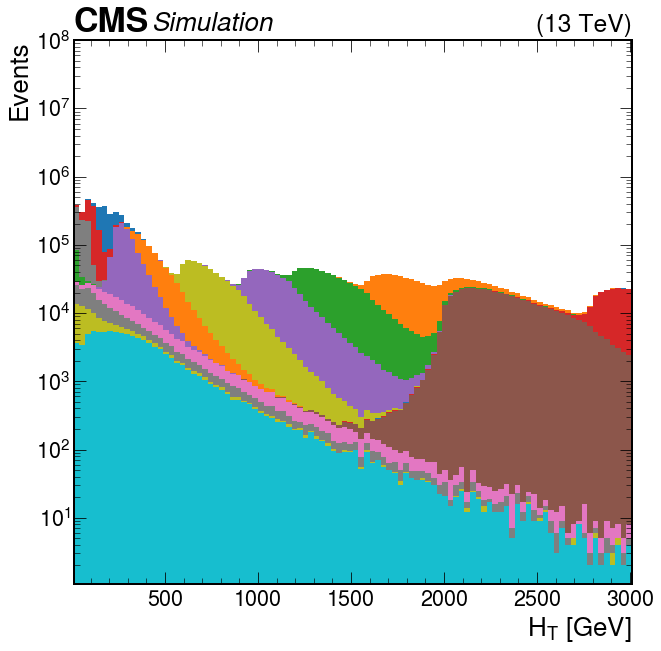

In [20]:
fig = plt.figure()
ax = fig.subplots()

import mplhep as hep
#hep.cms.label(data=False, year='2018')
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)
#_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
plot.plot1d(output["ht_ak4"], overlay='dataset', stack=True)

_ = ax.set_ylim(0, 100000000)
#_ = ax.set_xlim(0, 50000)
ax.get_legend().remove()

In [58]:
output

{'ht_ak4': <Hist (dataset,ht_ak4) instance at 0x7f5bf3389400>,
 'ntracks': <Hist (dataset,ntracks) instance at 0x7f5bf35301f0>,
 'sumw': defaultdict_accumulator(float,
                         {'QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM': 480000.0,
                          'QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM': 963000.0,
                          'QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM': 480000.0,
                          'QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM': 459000.0,
                          'QCD_Pt_120to170_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM': 864010.5908203125,
                          'QCD_Pt_1800to2400_TuneCP

In [49]:
h = output['ht_ak4']["QCD"]
h2 = h.rebin("ht_ak4", hist.Bin("znew", "rebinned z value", [0,100,1000]))
plot.plot1d(h2, clear=False, density=True)

AttributeError: 'str' object has no attribute 'Bin'

/home/submit/lavezzo/miniconda3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/submit/lavezzo/miniconda3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/submit/lavezzo/miniconda3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/submit/lavezzo/miniconda3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/submit/lavezzo/miniconda3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encounter

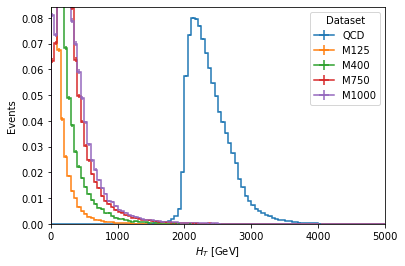

In [17]:
fig = plt.figure()
ax = fig.subplots()
plot.plot1d(output['ht_ak4']["QCD"], ax=ax, clear=False, density=True)
plot.plot1d(output['ht_ak4']["M125"], ax=ax, clear=False, density=True)
plot.plot1d(output['ht_ak4']["M400"], ax=ax, clear=False, density=True)
plot.plot1d(output['ht_ak4']["M750"], ax=ax, clear=False, density=True)
plot.plot1d(output['ht_ak4']["M1000"], ax=ax, clear=False, density=True)
_ = ax.set_xlim(0,5000)

In [66]:
default_colors = {
    'QCD': 'midnightblue',
    'SUEP-m1000-darkPho': 'red',
    'SUEP-m1000-darkPhoHad': 'red',
    'SUEP-m1000-generic': 'red',
    'SUEP-m750-darkPho': 'orange',
    'SUEP-m750-darkPhoHad': 'orange',
    'SUEP-m750-generic': 'orange',
    'SUEP-m400-darkPho': 'green',
    'SUEP-m400-darkPhoHad': 'green',
    'SUEP-m400-generic': 'green',
    'SUEP-m125-darkPho': 'cyan',
    'SUEP-m125-darkPhoHad': 'cyan',
    'SUEP-m125-generic': 'cyan',
        
}

def plot1d(h, ax, label, rebin=-1, color='default', lw=1):
    
    if color == 'default': color = default_colors[label]
    if label == 'QCD' and lw==1: lw=3
    
    y, x = h.to_numpy()    
    e = np.sqrt(y)
    x = x[:-1]
    if rebin!=-1: x, y, e = combine_bins(x, y, e, n=rebin)
    
    #ax.step(x[:-1],values, label=label, color=color, lw=lw)
    ax.errorbar(x, y, yerr=e, label=label, lw=lw, color=color, fmt="", drawstyle='steps-mid')
    ax.set_xlabel(h.axes[0].label)
    ax.set_ylabel("Events")
    
def plot2d(h, ax, log=False):
    w, x, y = h.to_numpy()
    if log: mesh = ax.pcolormesh(x, y, w.T, cmap="RdYlBu", norm=matplotlib.colors.LogNorm())
    else: mesh = ax.pcolormesh(x, y, w.T, cmap="RdYlBu")
    ax.set_xlabel(h.axes[0].label)
    ax.set_ylabel(h.axes[1].label)
    fig.colorbar(mesh)

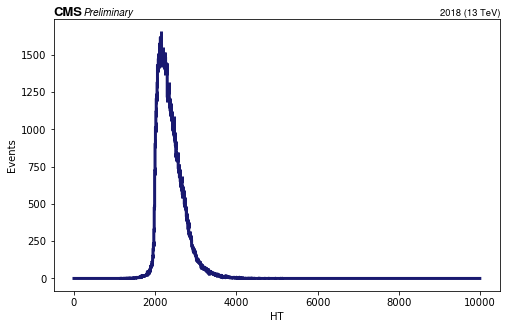

In [67]:
fig, ax = plt.subplots(figsize=(8,5))
hep.cms.label("Preliminary", data=True, year=2018)
plot1d(output['ht'], ax, 'QCD')

(0.0, 100.0)

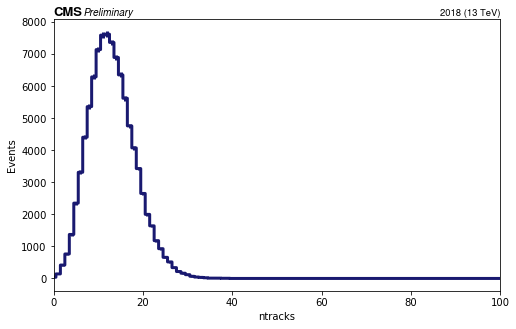

In [68]:
fig, ax = plt.subplots(figsize=(8,5))
hep.cms.label("Preliminary", data=True, year=2018)
plot1d(output['ntracks'], ax, 'QCD')
ax.set_xlim(0,100)

(0.0, 100.0)

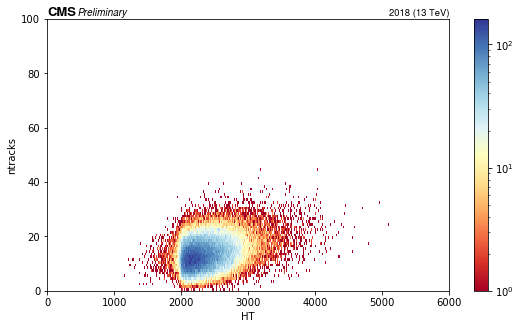

In [71]:
 fig, ax = plt.subplots(figsize=(9,5))
hep.cms.label("Preliminary", data=True, year=2018)

# plot QCD, sum values and errs
plot2d(output['2D_ht_ntracks'], ax, log=True)
ax.set_xlim(0,6000)
ax.set_ylim(0,100)